<a href="https://colab.research.google.com/github/elly760/AI-projects/blob/main/mobilenetv2-image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import os
import random
import shutil
import time
from matplotlib import pyplot as plt
from easydict import EasyDict
from PIL import Image

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore import Tensor
from mindspore.train.model import Model
from mindspore.train.serialization import load_checkpoint, save_checkpoint, export
from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mobilenetV2 import MobileNetV2Backbone, MobileNetV2Head, mobilenet_v2 # 模型定义脚本

ModuleNotFoundError: No module named 'mindspore'

In [ ]:
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend") # 设置采用图模式执行，设备为Ascend

In [ ]:
# 垃圾分类数据集标签，以及用于标签映射的字典。
garbage_classes = {
'可回收物': ['塑料瓶','帽子','报纸', '易拉罐',  '玻璃制品', '玻璃瓶', '硬纸板','篮球', '纸张', '金属制品'],
'干垃圾': ['一次性筷子', '打火机', '扫把', '旧镜子', '牙刷', '脏污衣服','贝壳', '陶瓷碗'],
'有害垃圾': ['油漆桶','电池', '荧光灯','药片胶囊'],
'湿垃圾': ['橙皮','菜叶', '蛋壳', '香蕉皮']
}
class_cn = ['塑料瓶','帽子','报纸', '易拉罐',  '玻璃制品', '玻璃瓶', '硬纸板','篮球', '纸张', '金属制品',
            '一次性筷子', '打火机', '扫把', '旧镜子', '牙刷', '脏污衣服','贝壳', '陶瓷碗',
           '油漆桶','电池', '荧光灯','药片胶囊'
           '橙皮','菜叶', '蛋壳', '香蕉皮']
class_en = ['Plastic Bottle', 'Hats', 'Newspaper', 'Cans', 'Glassware', 'Glass Bottle', 'Cardboard', 'Basketball', 'Paper', 'Metalware', 'Disposable Chopsticks', 'Lighter', 'Broom', 'Old Mirror', 'Toothbrush', 'Dirty Cloth', 'Seashell', 'Ceramic Bowl', 'Paint bucket','Battery', 'Fluorescent lamp', 'Tablet capsules', 'Orange Peel', 'Vegetable Leaf', 'Eggshell', 'Banana Peel'
]
index_en  = {'Plastic Bottle':0, 'Hats':1, 'Newspaper':2, 'Cans':3, 'Glassware':4, 'Glass Bottle':5, 'Cardboard':6, 'Basketball':7, 'Paper':8, 'Metalware':9, 'Disposable Chopsticks':10, 'Lighter':11, 'Broom':12, 'Old Mirror':13, 'Toothbrush':14, 'Dirty Cloth':15, 'Seashell':16, 'Ceramic Bowl':17, 'Paint bucket':18,'Battery':19, 'Fluorescent lamp':20, 'Tablet capsules':21, 'Orange Peel':22, 'Vegetable Leaf':23, 'Eggshell':24, 'Banana Peel':25
}

In [ ]:
# 训练超参
config = EasyDict({
    "num_classes": 26,
    "image_height": 224,
    "image_width": 224,
    #"data_split": [0.9, 0.1],
    "backbone_out_channels":1280,
    "batch_size": 64,
    "eval_batch_size": 8,
    "epochs": 30, #
    "lr_max": 0.05,
    "momentum": 0.9,
    "weight_decay": 1e-4, #
    "save_ckpt_epochs": 1,
    "save_ckpt_path": "./ckpt",
    "dataset_path": "./data_en",
    "class_index": index_en,
    "pretrained_ckpt": "./mobilenetV2-200_1067.ckpt" # mobilenetV2-200_1067.ckpt mobilenetv2_ascend.ckpt
})

In [ ]:
import os
import mindspore.common.dtype as mstype
import mindspore.dataset.engine as de
from mindspore.dataset import vision
from mindspore.dataset import transforms

def create_dataset(dataset_path, config, training=True, buffer_size=1000):
    """
    create a train or eval dataset

    Args:
        dataset_path(string): the path of dataset.
        config(struct): the config of train and eval in diffirent platform.

    Returns:
        train_dataset, val_dataset
    """
    data_path = os.path.join(dataset_path, 'train' if training else 'test')
    ds = de.ImageFolderDataset(data_path, num_parallel_workers=4, class_indexing=config.class_index)
    resize_height = config.image_height
    resize_width = config.image_width

    # define operations mapping to each sample
    normalize_op = vision.Normalize(mean=[0.485*255, 0.456*255, 0.406*255], std=[0.229*255, 0.224*255, 0.225*255])
    change_swap_op = vision.HWC2CHW()
    type_cast_op = transforms.TypeCast(mstype.int32)

    if training:
        # operations for training
        crop_decode_resize = vision.RandomCropDecodeResize(resize_height, scale=(0.08, 1.0), ratio=(0.75, 1.333))
        horizontal_flip_op = vision.RandomHorizontalFlip(prob=0.5)
        color_adjust = vision.RandomColorAdjust(brightness=0.4, contrast=0.4, saturation=0.4)

        train_trans = [crop_decode_resize, horizontal_flip_op, color_adjust, normalize_op, change_swap_op]
        train_ds = ds.map(input_columns="image", operations=train_trans, num_parallel_workers=8)
        train_ds = train_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=8)

        # apply shuffle operations
        train_ds = train_ds.shuffle(buffer_size=buffer_size)
        # apply batch operations
        ds = train_ds.batch(config.batch_size, drop_remainder=True)
    else:
        # operations for inference
        decode_op = vision.Decode()
        resize_op = vision.Resize((int(resize_width/0.875), int(resize_width/0.875)))
        center_crop = vision.CenterCrop(resize_width)

        eval_trans = [decode_op, resize_op, center_crop, normalize_op, change_swap_op]
        eval_ds = ds.map(input_columns="image", operations=eval_trans, num_parallel_workers=8)
        eval_ds = eval_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=8)
        ds = eval_ds.batch(config.eval_batch_size, drop_remainder=True)

    return ds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


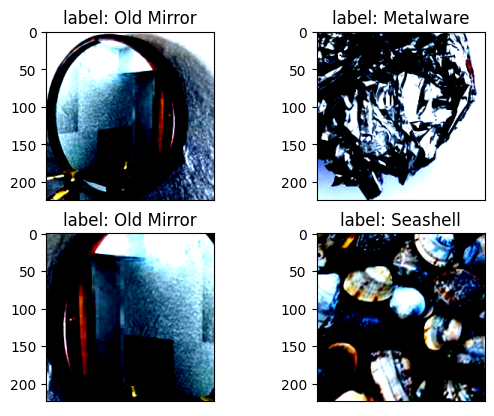

In [ ]:
ds = create_dataset(dataset_path=config.dataset_path, config=config, training=False)
print(ds.get_dataset_size())
data = ds.create_dict_iterator(output_numpy=True)._get_next()
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title('label: %s' % class_en[labels[i]])
    plt.xticks([])
plt.show()

In [ ]:
def cosine_decay(total_steps, lr_init=0.0, lr_end=0.0, lr_max=0.1, warmup_steps=0):
    """
    Applies cosine decay to generate learning rate array.

    Args:
       total_steps(int): all steps in training.
       lr_init(float): init learning rate.
       lr_end(float): end learning rate
       lr_max(float): max learning rate.
       warmup_steps(int): all steps in warmup epochs.

    Returns:
       list, learning rate array.
    """
    lr_init, lr_end, lr_max = float(lr_init), float(lr_end), float(lr_max)
    decay_steps = total_steps - warmup_steps
    lr_all_steps = []
    inc_per_step = (lr_max - lr_init) / warmup_steps if warmup_steps else 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * (i + 1)
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (i - warmup_steps) / decay_steps))
            lr = (lr_max - lr_end) * cosine_decay + lr_end
        lr_all_steps.append(lr)

    return lr_all_steps

In [ ]:
class EvalCallback(Callback):
    def __init__(self, model, eval_dataset, history, eval_epochs=1):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_epochs = eval_epochs
        self.history = history
        self.acc_max = 0
        # acc连续5次<=过程中的最大值，则停止训练
        self.count_max = 5
        self.count = 0

    def on_train_epoch_begin(self, run_context):
        self.losses = []
        self.startime = time.time()

    def on_train_step_end(self, run_context):
        cb_param = run_context.original_args()
        loss = cb_param.net_outputs
        self.losses.append(loss.asnumpy())

    def on_train_epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        train_loss = np.mean(self.losses)
        time_cost = time.time() - self.startime
        if cur_epoch % self.eval_epochs == 0:
            metric = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.history["epoch"].append(cur_epoch)
            self.history["eval_acc"].append(metric["acc"])
            self.history["eval_loss"].append(metric["loss"])
            self.history["train_loss"].append(train_loss)
            self.history["time_cost"].append(time_cost)
            if self.acc_max < metric["acc"]:
                self.count = 0
                self.acc_max = metric["acc"]
            else:
                self.count += 1
                if self.count == self.count_max:
                    run_context.request_stop()
            print("epoch: %d, train_loss: %f, eval_loss: %f, eval_acc: %f, time_cost: %f" %(cur_epoch, train_loss, metric["loss"], metric["acc"], time_cost))

In [ ]:
LOSS_SCALE = 1024
def train():
    train_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    eval_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    step_size = train_dataset.get_dataset_size()

    backbone = MobileNetV2Backbone() #last_channel=config.backbone_out_channels
    # Freeze parameters of backbone. You can comment these two lines.
    for param in backbone.get_parameters():
        param.requires_grad = False
    # load parameters from pretrained model
    load_checkpoint(config.pretrained_ckpt, backbone)

    # head = MobileNetV2Head(num_classes=config.num_classes, last_channel=config.backbone_out_channels)
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)

    # define loss, optimizer, and model
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    loss_scale = FixedLossScaleManager(LOSS_SCALE, drop_overflow_update=False)
    lrs = cosine_decay(config.epochs * step_size, lr_max=config.lr_max)
    opt = nn.Momentum(network.trainable_params(), lrs, config.momentum, config.weight_decay, loss_scale=LOSS_SCALE)
    model = Model(network, loss, opt, loss_scale_manager=loss_scale, metrics={'acc', 'loss'})

    history = {'epoch': [], 'train_loss': [], 'eval_loss': [], 'eval_acc': [], 'time_cost':[]}
    eval_cb = EvalCallback(model, eval_dataset, history)
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=config.save_ckpt_epochs * step_size, keep_checkpoint_max=config.epochs)
    ckpt_cb = ModelCheckpoint(prefix="mobilenetv2", directory=config.save_ckpt_path, config=ckpt_cfg)
    cb = [eval_cb, ckpt_cb]
    model.train(config.epochs, train_dataset, callbacks=cb, dataset_sink_mode=False)

    return history

epoch: 1, train_loss: 1.449322, eval_loss: 0.636417, eval_acc: 0.810937, time_cost: 54.711032
epoch: 2, train_loss: 0.671875, eval_loss: 0.530733, eval_acc: 0.848437, time_cost: 5.410617
epoch: 3, train_loss: 0.524862, eval_loss: 0.443420, eval_acc: 0.865625, time_cost: 5.399745
epoch: 4, train_loss: 0.495641, eval_loss: 0.398292, eval_acc: 0.880078, time_cost: 3.340393
epoch: 5, train_loss: 0.426921, eval_loss: 0.332589, eval_acc: 0.905469, time_cost: 4.379759
epoch: 6, train_loss: 0.396919, eval_loss: 0.306310, eval_acc: 0.919922, time_cost: 6.053944
epoch: 7, train_loss: 0.372116, eval_loss: 0.302837, eval_acc: 0.914453, time_cost: 3.257793
epoch: 8, train_loss: 0.338801, eval_loss: 0.296822, eval_acc: 0.914062, time_cost: 3.967788
epoch: 9, train_loss: 0.400065, eval_loss: 0.271614, eval_acc: 0.922266, time_cost: 6.714429
epoch: 10, train_loss: 0.315108, eval_loss: 0.226018, eval_acc: 0.941406, time_cost: 3.552332
epoch: 11, train_loss: 0.308463, eval_loss: 0.248448, eval_acc: 0.93

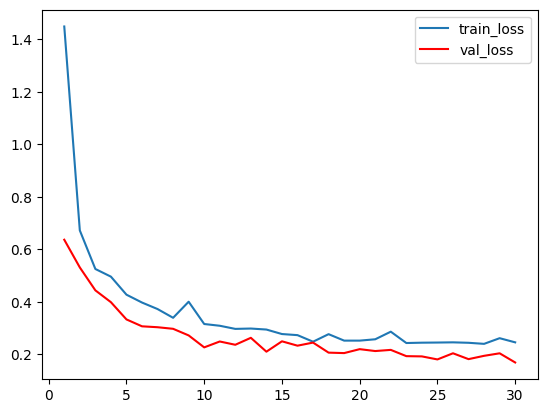

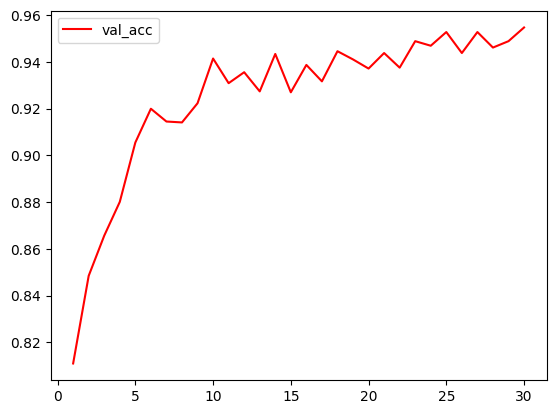

Chosen checkpoint is mobilenetv2-30_40.ckpt


In [ ]:
if os.path.exists(config.save_ckpt_path):
    shutil.rmtree(config.save_ckpt_path)

history = train()

plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['eval_loss'], 'r', label='val_loss')
plt.legend()
plt.show()

plt.plot(history['epoch'], history['eval_acc'], 'r', label = 'val_acc')
plt.legend()
plt.show()

CKPT = 'mobilenetv2-%d_40.ckpt' % (np.argmax(history['eval_acc']) + 1) # 挑选最优模型Checkpoint
print("Chosen checkpoint is", CKPT)

In [ ]:
def image_process(image):
    """Precess one image per time.

    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def infer_one(network, image_path):
    image = Image.open(image_path).resize((config.image_height, config.image_width))
    logits = network(image_process(image))
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    print(image_path, class_en[pred])

def infer():
    backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
    head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v2(backbone, head)
    load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)
    for i in range(91, 100):
        infer_one(network, f'data_en/test/Cardboard/000{i}.jpg')
infer()

data_en/test/Cardboard/00091.jpg Cardboard
data_en/test/Cardboard/00092.jpg Disposable Chopsticks
data_en/test/Cardboard/00093.jpg Cardboard
data_en/test/Cardboard/00094.jpg Cardboard
data_en/test/Cardboard/00095.jpg Cardboard
data_en/test/Cardboard/00096.jpg Cardboard
data_en/test/Cardboard/00097.jpg Cardboard
data_en/test/Cardboard/00098.jpg Cardboard
data_en/test/Cardboard/00099.jpg Cardboard


In [ ]:
backbone = MobileNetV2Backbone(last_channel=config.backbone_out_channels)
head = MobileNetV2Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
network = mobilenet_v2(backbone, head)
load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)

input = np.random.uniform(-1.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(network, Tensor(input), file_name='mobilenetv2', file_format='AIR')

In [ ]:
export(network, Tensor(input), file_name='mobilenetv2', file_format='MINDIR')